<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [1]:
# Imports
import re
import numpy as np
import pandas as pd
from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim import models
from gensim.models import CoherenceModel

# Visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
from explore_data import get_num_words_per_sample
from explore_data import plot_sample_length_distribution
from explore_data import plot_class_distribution
from explore_data import plot_frequency_distribution_of_ngrams
import seaborn as sns
sns.set()

# Leverage tqdm for progress_apply
from tqdm import tqdm
tqdm.pandas()

# SKLearn libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Set option to display more of the text in the columns
pd.set_option('display.max_colwidth', 300)

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\sahmj\anaconda3\envs\u4-s1-NLP\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# Download spacy model
import spacy
import spacy.cli
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [4]:
# Read in the data set of Amazon reviews
amazon = pd.read_csv('data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

# Look at the dataset
amazon.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batteries (36 Count),"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,Camcorder Batteries,Camera & Photo,Batteries,Household Batteries,Robot Check,Accessories,Camera Batteries,Health and Beauty,Household Supplies,Batteries & Chargers,Health, Household & Baby Care,Health Personal Care",Health & Beauty,"https://images-na.ssl-images-amazon.com/images/I/81qmNyJo%2BkL._SL1500_.jpg,https://images-na.ssl-images-amazon.com/images/I/81ZTa1BrkzL._SL1500_.jpg,http://ecx.images-amazon.com/images/I/41pSoRu7UlL._SS40_.jpg,https://www.upccodesearch.com/images/barcode/0841710106442.png,https://images-na.ssl-...","amazonbasics/hl002619,amazonbasicsaaaperformancealkalinebatteries36count/b00lh3dmuo,0841710106442,841710106442,amazonbasicsaaaperformancealkalinebatteries36count/b00qwo9p0o",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9P0O/,I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.,... 3 of them and one of the item is bad quality. Is missing backup spring so I have ...,Byger yang,"https://www.barcodable.com/upc/841710106442,https://www.amazon.com/AmazonBasics-Performance-Alkaline-Batteries-Count/dp/B00LH3DMUO/,https://www.amazon.com/AmazonBasics-Performance-Alkaline-Batteries-Count/dp/B00LH3DMUO,https://www.amazon.com/AmazonBasics-Performance-Alkaline-Batteries-36-Pack/dp..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batteries (36 Count),"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,Camcorder Batteries,Camera & Photo,Batteries,Household Batteries,Robot Check,Accessories,Camera Batteries,Health and Beauty,Household Supplies,Batteries & Chargers,Health, Household & Baby Care,Health Personal Care",Health & Beauty,"https://images-na.ssl-images-amazon.com/images/I/81qmNyJo%2BkL._SL1500_.jpg,https://images-na.ssl-images-amazon.com/images/I/81ZTa1BrkzL._SL1500_.jpg,http://ecx.images-amazon.com/images/I/41pSoRu7UlL._SS40_.jpg,https://www.upccodesearch.com/images/barcode/0841710106442.png,https://images-na.ssl-...","amazonbasics/hl002619,amazonbasicsaaaperformancealkalinebatteries36count/b00lh3dmuo,0841710106442,841710106442,amazonbasicsaaaperformancealkalinebatteries36count/b00qwo9p0o",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9P0O/,Bulk is always the less expensive way to go for products like these,... always the less expensive way to go for products like,ByMG,"https://www.barcodable.com/upc/841710106442,https://www.amazon.com/AmazonBasics-Performance-Alkaline-Batteries-Count/dp/B00LH3DMUO/,https://www.amazon.com/AmazonBasics-Performance-Alkaline-Batteries-Count/dp/B00LH3DMUO,https://www.amazon.com/AmazonBasics-Performance-Alkaline-Batteries-36-Pack/dp..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batteries (36 Count),"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,Camcorder Batteries,Camera & Photo,Batteries,Household Batteries,Robot Check,Accessories,Camera Batteries,Health and Beauty,Household Supplies,Batteries & Chargers,Health, Household & Baby Care,Health Personal Care",Health & Beauty,"https://images-na.ssl-images-amazon.com/images/I/81qmNyJo%2BkL._SL1500_.jpg,https://images-na.ssl-images-amazon.com/images/I/81ZTa1BrkzL._SL1500_.jpg,http://ecx.images-amazon.com/images/I/41pSoRu7UlL._SS40_.jpg,https://www.upccodesearch.com/images/barcode/0841710106442.png,https://images-na.ssl-...","amazonbasics/hl002619,amazonbasicsaaaperformancealkalin

In [5]:
# Look at the keys (columns in the csv)
amazon.keys()

Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs'],
      dtype='object')

In [6]:
# Get the value counts on the brand column
amazon['brand'].value_counts()

# Found that their are some values with the same name but cased different, 
#   need to take care of the casing issue to group them together.

Amazon          16153
Amazonbasics    12169
AmazonBasics       10
Name: brand, dtype: int64

In [7]:
# What are the primary categories?
amazon['primaryCategories'].value_counts()

# Looks like I can clean these up a little better by 
#   combining some of them together, which means that I
#   can probably pass in few topics than the number of categories

Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Home & Garden                      2
Electronics,Furniture              2
Name: primaryCategories, dtype: int64

In [8]:
# Look at a few sample reviews to see what I am working with
amazon['reviews.text'].sample(5)

# Text seams to be cleaned already, 
#   so no real need for cleaning before tokenizing/lemmatizing.

11774                                                                                                             It's a battery...
6011                                                                                                                       Perfect!
6145                                                                                        Good deal. Good battery. No complaints.
18018    I would recommend the Fire Tablet to anyone. IT is very easy to set up, download apps and use. Movies are crisp and clear.
13082                                           The best ebook reader in the market. The text is crisp and I love the backlighting.
Name: reviews.text, dtype: object

In [9]:
# Pull out just the columns that will be useful for my needs
amazon = amazon[['id', 'name', 'primaryCategories', 'reviews.text', 'reviews.rating']]
amazon.head()

,id,name,primaryCategories,reviews.text,reviews.rating
0,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.,3
1,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,Bulk is always the less expensive way to go for products like these,4
2,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,Well they are not Duracell but for the price i am happy.,5
3,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,Seem to work as well as name brand batteries at a much better price,5
4,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,These batteries are very long lasting the price is great.,5


In [10]:
# Look at a sample of the new dataset
amazon.sample(5)

,id,name,primaryCategories,reviews.text,reviews.rating
7239,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,"The best batteries you can get for the price, i have been using it in my xbox controllers so far i am satisfied with the results.Update: my controller batteries just died after like one month of use, i was rarely using my controllers(playing games). So, don't expect longer life from thess batter...",5
8591,AVpe7xlELJeJML43ypLz,AmazonBasics AA Performance Alkaline Batteries (48 Count) - Packaging May Vary,Health & Beauty,Batteries were packaged good and seem fine,5
910,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,"These batteries are usually a good buy for the money. I have had leakage on one occasion and dead cells a couple of times, but overall I have been satisfied. I think these batteries are as good as any other on the market.",4
27485,AVqkIhxunnc1JgDc3kg_,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 GB, Tangerine - with Special Offers",Electronics,Good tablet. Gave as gift and person enjoys it. Recommend,5
6779,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,packed in 4.,5


In [11]:
# Load the spacy vocab library
nlp = spacy.load('en_core_web_md')

In [12]:
# Create a 'lemmas' column
def get_lemmas(x):
    lemmas = []
    for token in nlp(x):
        if (token.is_stop == False) and (token.is_punct == False) and (token.is_space == False):
            lemmas.append(token.lemma_)
    return lemmas

amazon['lemmas'] = amazon['reviews.text'].progress_apply(get_lemmas)

100%|██████████| 28332/28332 [03:49<00:00, 123.30it/s]


In [13]:
# Look at the first 5 rows to check my work
amazon.head()

,id,name,primaryCategories,reviews.text,reviews.rating,lemmas
0,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.,3,"[order, 3, item, bad, quality, miss, backup, spring, pc, aluminum, battery, work]"
1,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,Bulk is always the less expensive way to go for products like these,4,"[bulk, expensive, way, product, like]"
2,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,Well they are not Duracell but for the price i am happy.,5,"[Duracell, price, happy]"
3,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,Seem to work as well as name brand batteries at a much better price,5,"[work, brand, battery, well, price]"
4,AVpgNzjwLJeJML43Kpxn,AmazonBasics AAA Performance Alkaline Batteries (36 Count),Health & Beauty,These batteries are very long lasting the price is great.,5,"[battery, long, last, price, great]"


In [14]:
# Create dictionary - Maps a number to a word
id2word = corpora.Dictionary(amazon['lemmas'])

In [15]:
# Look at the amount of words now
len(id2word.keys())

9755

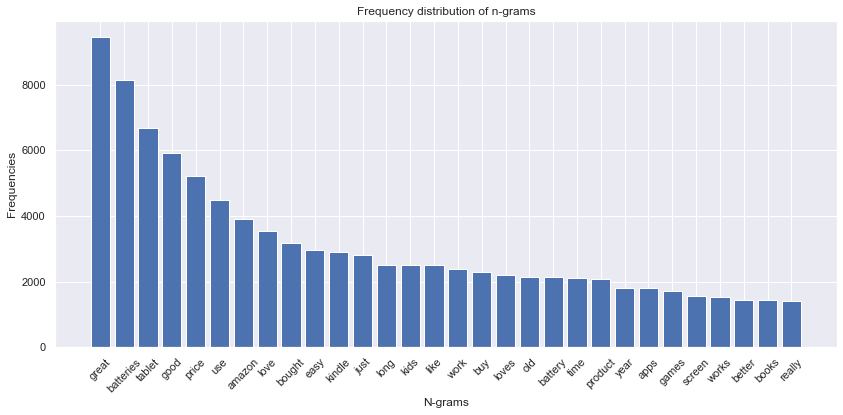

In [16]:
# Look at the count of the top 30 ngrams
plot_frequency_distribution_of_ngrams(amazon['reviews.text'],
                                      ngram_range=(1, 2),
                                      num_ngrams=30)

In [17]:
# Remove extreme values from the dataset
id2word.filter_extremes(no_below=3, no_above=0.80)

In [18]:
# Look at the amount of words now
len(id2word.keys())

4572

In [19]:
corpus = [id2word.doc2bow(text) for text in amazon['lemmas']]

In [20]:
# Look at a random review
amazon['reviews.text'][33]

'They seem to work okay so far and the price was great.'

In [21]:
# Look at the corpus for the review above
corpus[33]

[(11, 1), (19, 1), (22, 1), (177, 1), (178, 1)]

In [22]:
# Human readable format of the corpus (term-frequency)
[(id2word[word_id], word_count) for word_id, word_count in corpus[33]]

[('work', 1), ('price', 1), ('great', 1), ('far', 1), ('okay', 1)]

In [39]:
%%time  
# If you have just 1 % in front it will only time what is on that line, 2 % in front gives time of whole cell
# Train an LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=7,
                                            chunksize=100,
                                            passes=10,
                                            per_word_topics=True)

Wall time: 1min 33s


In [24]:
lda_model.save('lda_model.model')

In [25]:
lda =  models.LdaModel.load('lda_model.model')

In [26]:
# View the top 10 words per topic
pprint(lda.print_topics())

[(0,
  '0.061*"tablet" + 0.055*"love" + 0.045*"use" + 0.035*"buy" + 0.026*"old" + '
  '0.022*"kid" + 0.020*"book" + 0.019*"game" + 0.018*"year" + 0.017*"like"'),
 (1,
  '0.083*"read" + 0.038*"screen" + 0.034*"app" + 0.031*"movie" + 0.030*"enjoy" '
  '+ 0.029*"download" + 0.024*"little" + 0.024*"watch" + 0.022*"internet" + '
  '0.016*"overall"'),
 (2,
  '0.124*"tablet" + 0.054*"perfect" + 0.044*"fast" + 0.038*"look" + '
  '0.035*"Amazon" + 0.030*"app" + 0.028*"life" + 0.027*"$" + 0.026*"web" + '
  '0.020*"value"'),
 (3,
  '0.318*"great" + 0.108*"price" + 0.077*"product" + 0.065*"work" + '
  '0.033*"quality" + 0.023*"money" + 0.019*"buy" + 0.017*"beat" + '
  '0.015*"check" + 0.014*"ad"'),
 (4,
  '0.281*"good" + 0.207*"easy" + 0.051*"price" + 0.044*"work" + 0.022*"issue" '
  '+ 0.022*"sale" + 0.021*"Friday" + 0.021*"Prime" + 0.017*"Black" + '
  '0.017*"fine"'),
 (5,
  '0.084*"need" + 0.071*"nice" + 0.067*"size" + 0.050*"son" + 0.044*"far" + '
  '0.036*"big" + 0.032*"case" + 0.028*"like" +

In [ ]:
# %%time
# # Compute Perplexity
# print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda,
#                                      corpus=corpus
#                                      texts=amazon['lemmas'],
#                                      dictionary=id2word,
#                                      coherence='u_mass')
# coherence_lda = coherence_model_lda.get_coherence()
# print('\nCoherence Score: ', coherence_lda)  # Above .7 great model, below .3 bad model

# ^--- Having problems with the coherence taking too long to run.
#      Therefore commentting this out since I am running out of time to turn in assignment.
#      Need to circle back around to debug this issue.

In [27]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, id2word)
pyLDAvis.display(vis)

In [35]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """

    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                        id2word=id2word,
                                                        num_topics=num_topics,
                                                        chunksize=300,
                                                        passes=10,
                                                        per_word_topics=True,
                                                        workers=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [36]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=amazon['lemmas'],
                                                        start=2,
                                                        limit=30,
                                                        step=2)

Wall time: 13min 3s


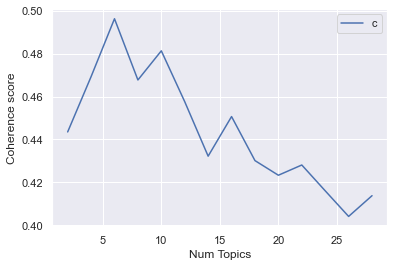

In [38]:
start=2; limit=30; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best');

In [40]:
%%time
# Train an LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=6,
                                            chunksize=300,
                                            passes=10,
                                            per_word_topics=True)

KeyboardInterrupt: 

In [41]:
lda_model.save('lda_model.model')

In [42]:
lda =  models.LdaModel.load('lda_model.model')

In [43]:
# View the top 10 words per topic
pprint(lda.print_topics())

[(0,
  '0.364*"great" + 0.159*"good" + 0.128*"price" + 0.085*"work" + '
  '0.039*"little" + 0.023*"money" + 0.023*"value" + 0.020*"deal" + 0.009*"far" '
  '+ 0.008*"glad"'),
 (1,
  '0.070*"book" + 0.056*"good" + 0.044*"screen" + 0.041*"nice" + 0.039*"read" '
  '+ 0.039*"size" + 0.031*"well" + 0.029*"son" + 0.025*"price" + '
  '0.023*"battery"'),
 (2,
  '0.107*"tablet" + 0.063*"app" + 0.043*"Amazon" + 0.040*"product" + '
  '0.029*"watch" + 0.027*"recommend" + 0.023*"movie" + 0.021*"download" + '
  '0.016*"ipad" + 0.014*"$"'),
 (3,
  '0.123*"kindle" + 0.069*"fast" + 0.039*"long" + 0.034*"user" + '
  '0.034*"awesome" + 0.034*"learn" + 0.032*"HD" + 0.027*"grandson" + '
  '0.027*"friendly" + 0.027*"time"'),
 (4,
  '0.076*"use" + 0.031*"game" + 0.030*"get" + 0.029*"Kindle" + 0.029*"Fire" + '
  '0.026*"play" + 0.023*"want" + 0.020*"read" + 0.017*"8" + 0.017*"device"'),
 (5,
  '0.212*"love" + 0.086*"like" + 0.043*"perfect" + 0.027*"child" + '
  '0.026*"quality" + 0.023*"amazon" + 0.021*"come" 

In [46]:
# %%time
# Compute Perplexity
print('\nPerplexity: ', lda.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda,
                                     corpus=corpus,
                                     texts=amazon['lemmas'],
                                     dictionary=id2word,
                                     coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Final Coherence Score does not look right,
#   need to look at this with fresh eyes tomorrow
#   to see if I can figure out where I went wrong.


Perplexity:  -7.092262837165051

Coherence Score:  -4.068616590083496


## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling